In [117]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier, SGDRegressor
import lightgbm as lgb
from matplotlib import pyplot as plt
import joblib
from pathlib import Path
import sqlite3

In [118]:
pd.options.display.max_rows=100
pd.options.display.max_columns=50

In [119]:
def create_results_df():
    
    path_to_results = Path().home().joinpath('NBA_Model_v1', 'results', 'betting_predictions_2022.csv')
    path_to_db = Path.home().joinpath('NBA_Model_v1', 'data', 'nba.db')
    season = '2022-23'
        
    preds = pd.read_csv(path_to_results)
    preds = preds.drop_duplicates(subset=['home_team', 'away_team', 'game_date'], keep='last')

    connection = sqlite3.connect(path_to_db)
    scores = pd.read_sql(f"""SELECT a.SEASON
                            ,a.GAME_DATE
                            ,a.TEAM_ABBREVIATION AS HOME_TEAM_ABBREVIATION
                            ,b.TEAM_ABBREVIATION AS AWAY_TEAM_ABBREVIATION
                            ,a.PTS AS HOME_TEAM_SCORE
                            ,b.PTS AS AWAY_TEAM_SCORE 
                        FROM team_basic_boxscores a
                        JOIN team_basic_boxscores b
                        ON a.GAME_ID = b.GAME_ID
                        WHERE a.MATCHUP like '%vs%'
                        and a.TEAM_ABBREVIATION != b.TEAM_ABBREVIATION
                        and a.SEASON = '{season}'""", con = connection)

    scores['GAME_DATE'] = pd.to_datetime(scores['GAME_DATE']).astype(str)

    merged = pd.merge(preds, scores, how='left', 
                    left_on = ['home_team', 'game_date'],
                    right_on = ['HOME_TEAM_ABBREVIATION', 'GAME_DATE'])

    merged['SGD_ATS_DIFF'] = merged['sgd_home_score_pred'] - merged['sgd_away_score_pred'] + merged['home_spread']
    merged['LGB_ATS_DIFF'] = merged['lgb_home_score_pred'] - merged['lgb_away_score_pred'] + merged['home_spread']

    merged['SGD_ATS_BET_HOME'] = (merged['SGD_ATS_DIFF']>0).astype(int)
    merged['LGB_ATS_BET_HOME'] = (merged['LGB_ATS_DIFF']>0).astype(int)

    merged['HOME_SCORE_DIFF'] = merged['HOME_TEAM_SCORE'] - merged['AWAY_TEAM_SCORE']
    merged['HOME_WIN'] = (merged['HOME_SCORE_DIFF']>0).astype(int)

    merged['HOME_COVER'] = ((merged['HOME_SCORE_DIFF'] + merged['home_spread']) > 0).astype(int)
    merged.loc[(merged['HOME_SCORE_DIFF'] + merged['home_spread']) == 0, 'HOME_COVER'] = np.nan

    merged['SGD_ATS_BET_RESULT'] = (merged['HOME_COVER'] == merged['SGD_ATS_BET_HOME']).astype(int)
    merged['LGB_ATS_BET_RESULT'] = (merged['HOME_COVER'] == merged['LGB_ATS_BET_HOME']).astype(int)


    merged['SGD_HINGE_ML_BET_RESULT'] = (merged['home_win_prob_sgd_hinge'] == merged['HOME_WIN']).astype(int)
    merged['SGD_LOGLOSS_ML_BET_RESULT'] = (merged['home_win_prob_sgd_logloss'].round() == merged['HOME_WIN']).astype(int)
    merged['LGB_ML_BET_RESULT'] = (merged['home_win_prob_lgbc'].round() == merged['HOME_WIN']).astype(int)


    merged.loc[merged['HOME_SCORE_DIFF'].isnull(), ['HOME_WIN', 'HOME_COVER', 'SGD_ATS_BET_RESULT',
                                                    'LGB_ATS_BET_RESULT', 'SGD_HINGE_ML_BET_RESULT',
                                                    'SGD_LOGLOSS_ML_BET_RESULT', 'LGB_ML_BET_RESULT']] = np.nan


    merged = merged.drop(columns = ['GAME_DATE', 'SEASON', 'HOME_TEAM_ABBREVIATION'])
    
    return merged

In [120]:
results = create_results_df()

results

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,HOME_COVER,SGD_ATS_BET_RESULT,LGB_ATS_BET_RESULT,SGD_HINGE_ML_BET_RESULT,SGD_LOGLOSS_ML_BET_RESULT,LGB_ML_BET_RESULT
0,DET,ORL,2022-10-19,-3.0,1.689655,2.250000,113.409544,111.058845,107.903390,108.971230,1,0.623637,0.376363,0.487241,0.512759,ORL,113.0,109.0,-0.649301,-4.067840,0,0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
1,IND,WAS,2022-10-19,1.0,1.952381,1.869565,115.204471,116.127576,115.438471,114.960548,1,0.462378,0.537622,0.359084,0.640916,WAS,107.0,114.0,0.076895,1.477923,1,1,-7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,BKN,NOP,2022-10-19,-3.0,1.666667,2.300000,110.883008,108.779141,111.617561,105.747313,0,0.707338,0.292662,0.545411,0.454589,NOP,108.0,130.0,-0.896133,2.870248,0,1,-22.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,MEM,NYK,2022-10-19,-4.0,1.571429,2.500000,104.937682,109.503584,106.732776,105.929732,0,0.396311,0.603689,0.392375,0.607625,NYK,115.0,112.0,-8.565902,-3.196956,0,0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,ATL,HOU,2022-10-19,-9.5,1.222222,4.600000,115.801929,110.365446,116.699032,108.988385,1,0.730860,0.269140,0.794196,0.205804,HOU,117.0,107.0,-4.063517,-1.789354,0,0,10.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,MEM,UTA,2023-01-08,-7.5,1.333333,3.500000,118.733679,113.071600,121.650011,116.888501,1,0.752018,0.247982,0.710611,0.289389,NaN,NaN,NaN,-1.837921,-2.738490,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,HOU,MIN,2023-01-08,2.0,2.100000,1.769231,114.342308,115.644803,111.442395,116.925629,0,0.445914,0.554086,0.359380,0.640620,NaN,NaN,NaN,0.697505,-3.483234,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,OKC,DAL,2023-01-08,-3.5,1.606061,2.400000,113.881409,113.832883,115.116686,118.622587,0,0.507150,0.492850,0.394982,0.605018,NaN,NaN,NaN,-3.451474,-7.005901,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599,PHX,CLE,2023-01-08,4.5,2.600000,1.526316,103.473901,102.580682,104.995993,110.486784,0,0.608784,0.391216,0.379541,0.620459,NaN,NaN,NaN,5.393219,-0.990791,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
results['home_score_err'] = results['sgd_home_score_pred'] - results['HOME_TEAM_SCORE']
results['away_score_err'] = results['sgd_away_score_pred'] - results['AWAY_TEAM_SCORE']

In [122]:
home_betting_results = results.groupby(['home_team'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count')).reset_index().rename(columns={
                                                                                                                 'sum':'home_ats_wins',
                                                                                                                 'count':'home_num_games'})


away_betting_results = results.groupby(['away_team'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count')).reset_index().rename(columns={
                                                                                                                 'sum':'away_ats_wins',
                                                                                                                 'count':'away_num_games'})


betting_stats_by_team = pd.merge(home_betting_results, away_betting_results, how='inner', left_on = 'home_team', right_on='away_team')
betting_stats_by_team['ats_wins'] = betting_stats_by_team['home_ats_wins'] + betting_stats_by_team['away_ats_wins']
betting_stats_by_team['num_games'] = betting_stats_by_team['home_num_games'] + betting_stats_by_team['away_num_games']
betting_stats_by_team['ats_pct'] = betting_stats_by_team['ats_wins'] / betting_stats_by_team['num_games']

betting_stats_by_team = betting_stats_by_team.drop(columns=['away_team'])

betting_stats_by_team.sort_values('ats_pct', ascending=False)

,home_team,home_ats_wins,home_num_games,away_ats_wins,away_num_games,ats_wins,num_games,ats_pct
9,GSW,12.0,20,14.0,19,26.0,39,0.666667
28,UTA,13.0,19,14.0,23,27.0,42,0.642857
4,CHI,9.0,20,16.0,20,25.0,40,0.625000
27,TOR,10.0,21,13.0,18,23.0,39,0.589744
17,MIN,13.0,21,10.0,19,23.0,40,0.575000
22,PHI,14.0,22,7.0,15,21.0,37,0.567568
29,WAS,12.0,17,10.0,23,22.0,40,0.550000
19,NYK,10.0,20,12.0,20,22.0,40,0.550000
10,HOU,11.0,19,10.0,20,21.0,39,0.538462
0,ATL,12.0,19,9.0,20,21.0,39,0.538462


In [123]:
results['bet_favorite'] = (((results['home_spread'] < 0) & (results['SGD_ATS_BET_HOME'] == 1)) 
                           |((results['home_spread'] > 0) & (results['SGD_ATS_BET_HOME'] == 0))).astype(int)

results['home_point_pred_winner'] = (results['sgd_home_score_pred'] - results['sgd_away_score_pred'] > 0).astype(int)
results['point_pred_correct'] = (results['home_point_pred_winner'] == results['HOME_WIN']).astype(int)

results['home_point_diff_pred'] = results['sgd_home_score_pred'] - results['sgd_away_score_pred']


results['model_fav_eq_vegas_fav'] = (np.sign(results['home_spread']) != np.sign(results['home_point_diff_pred'])).astype(int)

results['spread_diff<1'] = (results['SGD_ATS_DIFF'].abs() < 1).astype(int)
results['spread_diff>1'] = (results['SGD_ATS_DIFF'].abs() >= 1).astype(int)
results['spread_diff>2'] = (results['SGD_ATS_DIFF'].abs() >= 2).astype(int)
results['spread_diff>3'] = (results['SGD_ATS_DIFF'].abs() >= 3).astype(int)
results['spread_diff>4'] = (results['SGD_ATS_DIFF'].abs() >= 4).astype(int)



In [124]:
results[['home_team', 'away_team', 'game_date', 'home_spread', 'SGD_ATS_BET_HOME',
         'bet_favorite', 'SGD_ATS_DIFF', 'SGD_ATS_BET_RESULT', 
         'home_point_diff_pred', 'model_fav_eq_vegas_fav', 'spread_diff<1',
         'spread_diff>1','spread_diff>2','spread_diff>3','spread_diff>4']]

,home_team,away_team,game_date,home_spread,SGD_ATS_BET_HOME,bet_favorite,SGD_ATS_DIFF,SGD_ATS_BET_RESULT,home_point_diff_pred,model_fav_eq_vegas_fav,spread_diff<1,spread_diff>1,spread_diff>2,spread_diff>3,spread_diff>4
0,DET,ORL,2022-10-19,-3.0,0,0,-0.649301,0.0,2.350699,1,1,0,0,0,0
1,IND,WAS,2022-10-19,1.0,1,0,0.076895,0.0,-0.923105,1,1,0,0,0,0
2,BKN,NOP,2022-10-19,-3.0,0,0,-0.896133,1.0,2.103867,1,1,0,0,0,0
3,MEM,NYK,2022-10-19,-4.0,0,0,-8.565902,1.0,-4.565902,0,0,1,1,1,1
4,ATL,HOU,2022-10-19,-9.5,0,0,-4.063517,0.0,5.436483,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,MEM,UTA,2023-01-08,-7.5,0,0,-1.837921,NaN,5.662079,1,0,1,0,0,0
597,HOU,MIN,2023-01-08,2.0,1,0,0.697505,NaN,-1.302495,1,1,0,0,0,0
598,OKC,DAL,2023-01-08,-3.5,0,0,-3.451474,NaN,0.048526,1,0,1,1,1,0
599,PHX,CLE,2023-01-08,4.5,1,0,5.393219,NaN,0.893219,0,0,1,1,1,1


In [125]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                                    sum count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite                            
0                      0                0                          29.0    48   
                       1                0                          46.0    80   
1                      0                0                          69.0   160   
                                        1                          16.0    42   
                       1                0                          51.0    88   
                                        1                          89.0   174   

                                                                
                                                          mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite            
0                      0                0             0.604167  
                       1                0             0.575000  
1                      0                0             0.431250  
                                        1             0.380952  
                       1                0             0.579545  
                                        1             0.511494

In [126]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite', 'home_point_pred_winner'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                           sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner                      
0                      0                0            0                                    29.0   
                       1                0            1                                    46.0   
1                      0                0            0                                     1.0   
                                                     1                                    68.0   
                                        1            0                                    16.0   
                       1                0            0                                    50.0   
                                                     1                                     1.0   
                                        1            1                                    89.0   

                                                                                   \
                                                                            count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner         
0                      0                0            0                         48   
                       1                0            1                         80   
1                      0                0            0                          1   
                                                     1                        159   
                                        1            0                         42   
                       1                0            0                         86   
                                                     1                          2   
                                        1            1                        174   

                                                                                       
                                                                                 mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner            
0                      0                0            0                       0.604167  
                       1                0            1                       0.575000  
1                      0                0            0                       1.000000  
                                                     1                       0.427673  
                                        1            0                       0.380952  
                       1                0            0                       0.581395  
                                                     1                       0.500000  
                                        1            1                       0.511494

In [127]:
results.groupby(['SGD_ATS_BET_HOME', 'bet_favorite', 'home_point_pred_winner'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                                    sum count   
SGD_ATS_BET_HOME bet_favorite home_point_pred_winner                            
0                0            0                                    30.0    49   
                              1                                    68.0   159   
                 1            0                                    16.0    42   
1                0            0                                    50.0    86   
                              1                                    47.0    82   
                 1            1                                    89.0   174   

                                                                
                                                          mean  
SGD_ATS_BET_HOME bet_favorite home_point_pred_winner            
0                0            0                       0.612245  
                              1                       0.427673  
                 1            0                       0.380952  
1                0            0                       0.581395  
                              1                       0.573171  
                 1            1                       0.511494

In [128]:
results.groupby(['SGD_ATS_BET_HOME', 'bet_favorite'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                                             sum count      mean
SGD_ATS_BET_HOME bet_favorite                                   
0                0                          98.0   208  0.471154
                 1                          16.0    42  0.380952
1                0                          97.0   168  0.577381
                 1                          89.0   174  0.511494

In [129]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                     sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME spread_diff>3                      
0                      0                0                            7.0   
                                        1                           22.0   
                       1                0                            5.0   
                                        1                           41.0   
1                      0                0                           53.0   
                                        1                           32.0   
                       1                0                           82.0   
                                        1                           58.0   

                                                                       
                                                      count      mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME spread_diff>3                  
0                      0                0                15  0.466667  
                                        1                33  0.666667  
                       1                0                 8  0.625000  
                                        1                72  0.569444  
1                      0                0               127  0.417323  
                                        1                75  0.426667  
                       1                0               158  0.518987  
                                        1               104  0.557692

In [130]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite','spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                  sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite spread_diff>3                      
0                      0                0            0                            7.0   
                                                     1                           22.0   
                       1                0            0                            5.0   
                                                     1                           41.0   
1                      0                0            0                           42.0   
                                                     1                           27.0   
                                        1            0                           11.0   
                                                     1                            5.0   
                       1                0            0                           32.0   
                                                     1                           19.0   
                                        1            0                           50.0   
                                                     1                           39.0   

                                                                          \
                                                                   count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite spread_diff>3         
0                      0                0            0                15   
                                                     1                33   
                       1                0            0                 8   
                                                     1                72   
1                      0                0            0                97   
                                                     1                63   
                                        1            0                30   
                                                     1                12   
                       1                0            0                54   
                                                     1                34   
                                        1            0               104   
                                                     1                70   

                                                                              
                                                                        mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite spread_diff>3            
0                      0                0            0              0.466667  
                                                     1              0.666667  
                       1                0            0              0.625000  
                                                     1              0.569444  
1                      0                0            0              0.432990  
                                                     1              0.428571  
                                        1            0              0.366667  
                                                     1              0.416667  
                       1                0            0              0.592593  
                                                     1              0.558824  
                                        1            0              0.480769  
                                                     1              0.557143

In [131]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite', 'home_point_pred_winner','spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                                         sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>3                      
0                      0                0            0                      0                            7.0   
                                                                            1                           22.0   
                       1                0            1                      0                            5.0   
                                                                            1                           41.0   
1                      0                0            0                      1                            1.0   
                                                     1                      0                           42.0   
                                                                            1                           26.0   
                                        1            0                      0                           11.0   
                                                                            1                            5.0   
                       1                0            0                      0                           32.0   
                                                                            1                           18.0   
                                                     1                      0                            0.0   
                                                                            1                            1.0   
                                        1            1                      0                           50.0   
                                                                            1                           39.0   

                                                                                                 \
                                                                                          count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>3         
0                      0                0            0                      0                15   
                                                                            1                33   
                       1                0            1                      0                 8   
                                                                            1                72   
1                      0                0            0                      1                 1   
                                                     1                      0                97   
                                                                            1                62   
                                        1            0                      0                30   
                                                                            1                12   
                       1                0            0                      0                53   
                                                                            1                33   
                                                     1                      0                 1   
                                                                            1                 1   
                                        1            1                      0               104   
                                                                            1                70   

                                                                                                     
                                                                                               mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_dif

In [132]:
results.groupby(['spread_diff>3', 'SGD_ATS_BET_HOME', 'bet_favorite'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                                                           sum count      mean
spread_diff>3 SGD_ATS_BET_HOME bet_favorite                                   
0             0                0                          49.0   112  0.437500
                               1                          11.0    30  0.366667
              1                0                          37.0    62  0.596774
                               1                          50.0   104  0.480769
1             0                0                          49.0    96  0.510417
                               1                           5.0    12  0.416667
              1                0                          60.0   106  0.566038
                               1                          39.0    70  0.557143

In [133]:
results.groupby(['model_fav_eq_vegas_fav', 'bet_favorite', 'home_point_pred_winner','spread_diff>3', 'SGD_ATS_BET_HOME'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                                         sum   
model_fav_eq_vegas_fav bet_favorite home_point_pred_winner spread_diff>3 SGD_ATS_BET_HOME                      
0                      0            0                      0             0                               7.0   
                                                           1             0                              22.0   
                                    1                      0             1                               5.0   
                                                           1             1                              41.0   
1                      0            0                      0             1                              32.0   
                                                           1             0                               1.0   
                                                                         1                              18.0   
                                    1                      0             0                              42.0   
                                                                         1                               0.0   
                                                           1             0                              26.0   
                                                                         1                               1.0   
                       1            0                      0             0                              11.0   
                                                           1             0                               5.0   
                                    1                      0             1                              50.0   
                                                           1             1                              39.0   

                                                                                                 \
                                                                                          count   
model_fav_eq_vegas_fav bet_favorite home_point_pred_winner spread_diff>3 SGD_ATS_BET_HOME         
0                      0            0                      0             0                   15   
                                                           1             0                   33   
                                    1                      0             1                    8   
                                                           1             1                   72   
1                      0            0                      0             1                   53   
                                                           1             0                    1   
                                                                         1                   33   
                                    1                      0             0                   97   
                                                                         1                    1   
                                                           1             0                   62   
                                                                         1                    1   
                       1            0                      0             0                   30   
                                                           1             0                   12   
                                    1                      0             1                  104   
                                                           1             1                   70   

                                                                                                     
                                                                                               mean  
model_fav_eq_vegas_fav bet_favorite home_point_pred_winner spread_diff>3 SGD_ATS_BET_H

In [134]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                                    sum count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite                            
0                      0                0                          29.0    48   
                       1                0                          46.0    80   
1                      0                0                          69.0   160   
                                        1                          16.0    42   
                       1                0                          51.0    88   
                                        1                          89.0   174   

                                                                
                                                          mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite            
0                      0                0             0.604167  
                       1                0             0.575000  
1                      0                0             0.431250  
                                        1             0.380952  
                       1                0             0.579545  
                                        1             0.511494

In [135]:
results.groupby(['spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                             sum count      mean
spread_diff>3                                   
0                          147.0   308  0.477273
1                          153.0   284  0.538732

In [136]:
results.groupby(['home_point_pred_winner', 'bet_favorite'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_point_pred_winner bet_favorite                        
0                      0              80.0    135  0.592593
                       1              16.0     42  0.380952
1                      0             115.0    241  0.477178
                       1              89.0    174  0.511494

In [137]:
results.groupby(['home_point_pred_winner', 'SGD_ATS_BET_HOME'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_point_pred_winner SGD_ATS_BET_HOME                        
0                      0                  46.0     91  0.505495
                       1                  50.0     86  0.581395
1                      0                  68.0    159  0.427673
                       1                 136.0    256  0.531250

In [138]:
results.groupby(['home_point_pred_winner', 'SGD_ATS_BET_HOME', 'bet_favorite'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_point_pred_winner SGD_ATS_BET_HOME bet_favorite                       
0                      0                0             30.0     49  0.612245
                                        1             16.0     42  0.380952
                       1                0             50.0     86  0.581395
1                      0                0             68.0    159  0.427673
                       1                0             47.0     82  0.573171
                                        1             89.0    174  0.511494

In [139]:
results['sgd_prob_bin'] = pd.cut(results['home_win_prob_sgd_logloss'], np.arange(0,1.1,.1))

In [140]:
results.groupby('sgd_prob_bin')['SGD_ATS_BET_RESULT'].mean()

sgd_prob_bin
(0.0, 0.1]    0.000000
(0.1, 0.2]    0.400000
(0.2, 0.3]    0.520000
(0.3, 0.4]    0.596774
(0.4, 0.5]    0.522222
(0.5, 0.6]    0.530000
(0.6, 0.7]    0.511811
(0.7, 0.8]    0.440000
(0.8, 0.9]    0.507937
(0.9, 1.0]    0.368421
Name: SGD_ATS_BET_RESULT, dtype: float64

In [141]:
results[['home_score_err', 'away_score_err']].abs().mean()

home_score_err    9.216433
away_score_err    8.849535
dtype: float64

In [142]:
results

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,HOME_COVER,SGD_ATS_BET_RESULT,LGB_ATS_BET_RESULT,SGD_HINGE_ML_BET_RESULT,SGD_LOGLOSS_ML_BET_RESULT,LGB_ML_BET_RESULT,home_score_err,away_score_err,bet_favorite,home_point_pred_winner,point_pred_correct,home_point_diff_pred,model_fav_eq_vegas_fav,spread_diff<1,spread_diff>1,spread_diff>2,spread_diff>3,spread_diff>4,sgd_prob_bin
0,DET,ORL,2022-10-19,-3.0,1.689655,2.250000,113.409544,111.058845,107.903390,108.971230,1,0.623637,0.376363,0.487241,0.512759,ORL,113.0,109.0,-0.649301,-4.067840,0,0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.409544,2.058845,0,1,1,2.350699,1,1,0,0,0,0,"(0.6, 0.7]"
1,IND,WAS,2022-10-19,1.0,1.952381,1.869565,115.204471,116.127576,115.438471,114.960548,1,0.462378,0.537622,0.359084,0.640916,WAS,107.0,114.0,0.076895,1.477923,1,1,-7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.204471,2.127576,0,0,1,-0.923105,1,1,0,0,0,0,"(0.4, 0.5]"
2,BKN,NOP,2022-10-19,-3.0,1.666667,2.300000,110.883008,108.779141,111.617561,105.747313,0,0.707338,0.292662,0.545411,0.454589,NOP,108.0,130.0,-0.896133,2.870248,0,1,-22.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.883008,-21.220859,0,1,0,2.103867,1,1,0,0,0,0,"(0.7, 0.8]"
3,MEM,NYK,2022-10-19,-4.0,1.571429,2.500000,104.937682,109.503584,106.732776,105.929732,0,0.396311,0.603689,0.392375,0.607625,NYK,115.0,112.0,-8.565902,-3.196956,0,0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-10.062318,-2.496416,0,0,0,-4.565902,0,0,1,1,1,1,"(0.3, 0.4]"
4,ATL,HOU,2022-10-19,-9.5,1.222222,4.600000,115.801929,110.365446,116.699032,108.988385,1,0.730860,0.269140,0.794196,0.205804,HOU,117.0,107.0,-4.063517,-1.789354,0,0,10.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.198071,3.365446,0,1,1,5.436483,1,0,1,1,1,1,"(0.7, 0.8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,MEM,UTA,2023-01-08,-7.5,1.333333,3.500000,118.733679,113.071600,121.650011,116.888501,1,0.752018,0.247982,0.710611,0.289389,NaN,NaN,NaN,-1.837921,-2.738490,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,5.662079,1,0,1,0,0,0,"(0.7, 0.8]"
597,HOU,MIN,2023-01-08,2.0,2.100000,1.769231,114.342308,115.644803,111.442395,116.925629,0,0.445914,0.554086,0.359380,0.640620,NaN,NaN,NaN,0.697505,-3.483234,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,-1.302495,1,1,0,0,0,0,"(0.4, 0.5]"
598,OKC,DAL,2023-01-08,-3.5,1.606061,2.400000,113.881409,113.832883,115.116686,118.622587,0,0.507150,0.492850,0.394982,0.605018,NaN,NaN,NaN,-3.451474,-7.005901,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0.048526,1,0,1,1,1,0,"(0.5, 0.6]"
599,PHX,CLE,2023-01-08,4.5,2.600000,1.526316,103.473901,102.580682,104.995993,110.486784,0,0.608784,0.391216,0.379541,0.620459,NaN,NaN,NaN,5.393219,-0.990791,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0.893219,0,0,1,1,1,1,"(0.6, 0.7]"


In [143]:
# results['SGDAndHingeClassifierAgree'] = (results['home_win_prob_sgd_hinge'] == results['SGD_ATS_BET_HOME']).astype(int) 
# results['SGDRegAndHingeClassifier_betresult'] = (results['SGDRegAndHingeClassifier'] == results['HOME_COVER']).astype(int)

# results[['home_win_prob_sgd_hinge', 'SGD_ATS_BET_HOME', 'SGDRegAndHingeClassifier', 'HOME_COVER', 'SGDRegAndHingeClassifier_betresult']]

In [144]:
connection = sqlite3.connect('../data/nba.db')


df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup_prod', con=connection)
df = df.drop(columns=['index'])

connection.close()

df = df.sort_values('GAME_DATE')

df = df.dropna()

columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                     'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                     'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                     'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE',
                     'HOME_PTS_L5', 'HOME_PTS_L10', 'HOME_PTS_L20',
                     'HOME_PLUS_MINUS_L5', 'HOME_PLUS_MINUS_L10', 'HOME_PLUS_MINUS_L20',
                     'HOME_NET_RATING_L5', 'HOME_NET_RATING_L10', 'HOME_NET_RATING_L20',
                     'HOME_POSS_L5', 'HOME_POSS_L10', 'HOME_POSS_L20',
                     'HOME_PTS_opp_L5', 'HOME_PTS_opp_L10', 'HOME_PTS_opp_L20',
                     'HOME_PLUS_MINUS_opp_L5', 'HOME_PLUS_MINUS_opp_L10', 'HOME_PLUS_MINUS_opp_L20',
                     'HOME_NET_RATING_opp_L5', 'HOME_NET_RATING_opp_L10', 'HOME_NET_RATING_opp_L20',
                     'HOME_POSS_opp_L5', 'HOME_POSS_opp_L10', 'HOME_POSS_opp_L20',
                     'HOME_REB_L5', 'HOME_REB_L10', 'HOME_REB_L20',  
                     'HOME_REB_opp_L5', 'HOME_REB_opp_L10', 'HOME_REB_opp_L20',       
                     'AWAY_PTS_L5', 'AWAY_PTS_L10', 'AWAY_PTS_L20',
                     'AWAY_PLUS_MINUS_L5', 'AWAY_PLUS_MINUS_L10', 'AWAY_PLUS_MINUS_L20',
                     'AWAY_NET_RATING_L5', 'AWAY_NET_RATING_L10', 'AWAY_NET_RATING_L20',
                     'AWAY_POSS_L5', 'AWAY_POSS_L10', 'AWAY_POSS_L20',
                     'AWAY_PTS_opp_L5', 'AWAY_PTS_opp_L10', 'AWAY_PTS_opp_L20',
                     'AWAY_PLUS_MINUS_opp_L5', 'AWAY_PLUS_MINUS_opp_L10', 'AWAY_PLUS_MINUS_opp_L20',
                     'AWAY_NET_RATING_opp_L5', 'AWAY_NET_RATING_opp_L10', 'AWAY_NET_RATING_opp_L20',
                     'AWAY_POSS_opp_L5', 'AWAY_POSS_opp_L10', 'AWAY_POSS_opp_L20',
                     'AWAY_REB_L5', 'AWAY_REB_L10', 'AWAY_REB_L20',
                     'AWAY_REB_opp_L5', 'AWAY_REB_opp_L10', 'AWAY_REB_opp_L20']

train_df = df.loc[df['SEASON'] < '2021-22']
test_df = df.loc[df['SEASON'] >= '2021-22']


X_train = train_df.drop(columns=columns_to_drop)
y_train = train_df['HOME_WL']

X_test = test_df.drop(columns=columns_to_drop)
y_test = test_df['HOME_WL']

train_df.shape, test_df.shape

((9721, 645), (1813, 645))

In [145]:
X_train

,HOME_FG2M_L5,HOME_FG2A_L5,HOME_FG3M_L5,HOME_FG3A_L5,HOME_FTM_L5,HOME_FTA_L5,HOME_OREB_L5,HOME_DREB_L5,HOME_AST_L5,HOME_STL_L5,HOME_BLK_L5,HOME_TOV_L5,HOME_PF_L5,HOME_OFF_RATING_L5,HOME_DEF_RATING_L5,HOME_PACE_L5,HOME_DIST_L5,HOME_ORBC_L5,HOME_DRBC_L5,HOME_RBC_L5,HOME_TCHS_L5,HOME_SAST_L5,HOME_FTAST_L5,HOME_PASS_L5,HOME_CFGM_L5,...,AWAY_PTS_PAINT_opp_L20,AWAY_AST_2PM_opp_L20,AWAY_AST_3PM_opp_L20,AWAY_UAST_2PM_opp_L20,AWAY_UAST_3PM_opp_L20,AWAY_WIN_PCT_L20,AWAY_COVER_PCT_L20,AWAY_OREB_PCT_L20,AWAY_OREB_PCT_opp_L20,AWAY_DREB_PCT_L20,AWAY_DREB_PCT_opp_L20,AWAY_REB_PCT_L20,AWAY_REB_PCT_opp_L20,AWAY_TS_PCT_L20,AWAY_TS_PCT_opp_L20,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
0,31.518241,66.650047,11.148672,22.113305,21.954930,25.266237,14.512977,33.514702,23.799377,6.896403,4.892904,15.670359,18.286097,118.941411,104.783370,97.219694,17.268597,38.413916,68.283315,104.987538,430.957908,2.509451,2.952982,302.964715,18.651666,...,45.242919,15.287365,5.871573,14.216470,1.279883,0.60,0.50,0.224956,0.265469,0.734531,0.775044,0.475502,0.524498,0.571432,0.580626,0.514710,0.500641,24.305035,23.174242,12.574422,14.664175,0.503846,3.0,0,0
1,29.772751,66.803971,8.735208,19.678742,19.213618,27.270855,15.839389,36.529798,20.015921,9.338738,7.824332,18.266788,20.931006,103.482228,93.968118,96.661027,16.556187,37.638960,67.506907,102.517657,407.742987,2.522666,1.772158,282.160345,20.600457,...,38.141218,11.908363,7.855050,13.579718,0.997995,0.75,0.45,0.176923,0.277440,0.722560,0.823077,0.463654,0.536346,0.622182,0.568204,0.545240,0.483274,24.820241,21.489581,15.404898,17.281397,0.555548,1.0,1,0
2,34.273504,69.759524,3.891372,17.806949,20.125979,27.945182,11.645941,38.028180,20.752197,7.152998,5.085879,13.411039,18.963080,99.616421,95.171155,94.039456,17.176543,31.952021,66.897051,95.722675,478.397017,1.660482,2.635605,357.722287,24.923908,...,43.104701,13.308059,5.975659,17.604049,0.675752,0.55,0.40,0.250022,0.269241,0.730759,0.749978,0.500862,0.499138,0.585741,0.554306,0.514862,0.476606,23.658670,20.646725,14.860777,13.379923,0.514737,2.0,0,1
3,33.390751,69.422949,6.394982,23.334510,13.025644,19.490081,12.977680,33.674126,21.252429,6.894249,4.443567,17.136566,23.767165,97.672302,108.877499,97.666040,18.115212,40.813616,64.085373,99.804109,460.143906,2.926503,1.056664,327.136422,24.321332,...,45.205179,18.724199,5.029644,12.462624,0.987892,0.65,0.55,0.234652,0.267917,0.732083,0.765348,0.488230,0.511770,0.574779,0.545381,0.498716,0.472069,26.011999,25.555622,12.926552,13.817702,0.530071,2.0,0,0
4,34.559555,75.184094,7.061383,17.070850,19.556235,24.876820,13.514408,32.649867,21.339324,8.288540,5.034402,16.462951,26.478645,102.764466,114.868326,92.762064,17.547778,37.541232,64.559667,98.903753,472.369549,1.971538,1.925949,340.221004,19.650011,...,45.647225,14.837994,4.853054,18.489337,1.376487,0.85,0.75,0.308266,0.260045,0.739955,0.691734,0.525655,0.474345,0.594631,0.557912,0.523593,0.489991,24.703460,21.055164,13.115250,12.220492,0.544858,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9716,29.492041,60.368357,11.555680,30.822272,17.498432,19.858272,8.931630,37.753295,22.584900,6.634075,2.999236,11.076148,19.178353,115.975138,107.607505,96.973809,17.186404,21.180858,54.389695,73.412209,368.176594,2.681004,2.396946,248.593628,15.226875,...,40.553385,11.994369,9.123811,14.968019,3.203223,0.65,0.55,0.265845,0.199523,0.800477,0.734155,0.531844,0.468156,0.584924,0.584124,0.537944,0.526323,23.809528,22.230208,11.444715,11.881893,0.523776,2.0,0,0
9717,30.493746,57.694185,12.283340,35.919724,14.618955,21.250778,14.320567,33.437675,23.193631,8.131797,5.027797,12.112426,18.814806,113.256423,116.036072,97.188031,17.406062,29.878695,60.022346,88.397373,364.699502,3.959293,

In [146]:
def view_model_coefs(model, X_train, plot_graph = True, remove_zero_coefs=True):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})
    if remove_zero_coefs:
        coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    if plot_graph:
        top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
        top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

In [147]:
filename = 'SGDRegressor_ScorePredictor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_sgd_reg = joblib.load(model_location)


In [148]:
filename = 'LGBRegressor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_lgb_reg = joblib.load(model_location)

In [149]:
best_sgd_reg.named_steps['sgd'].estimators_[0].coef_

array([ 2.80880825e+00, -3.20719628e-01,  1.19598581e-02,  4.71026549e-01,
        5.59688012e-01, -4.49533007e-02,  8.85733451e-02, -1.69783857e-01,
       -2.90515878e-01, -1.27881132e-02,  3.59621152e-01, -1.12823613e-01,
       -6.36844578e-02, -2.32396840e-01,  1.49706209e-01,  5.03193883e-02,
       -1.49980905e-01,  3.42055847e-03,  1.65703061e-01,  1.14788885e-01,
       -1.70972815e-01, -1.31860151e-01, -1.37020654e-01, -1.74534994e-01,
       -2.03861187e-01,  8.13099212e-02, -5.18645795e-01,  3.44567840e-01,
        3.63015063e-01, -9.09469429e-02, -2.63718289e-01, -2.13768050e-01,
        4.01066415e-02, -4.77558974e-01, -2.13029498e-01,  2.93911455e-02,
       -5.92217953e-01, -1.05340415e-01, -3.39359214e-01, -5.01436110e-02,
        1.29260984e-02, -1.07664514e-01, -2.10011573e-01,  1.74036908e-02,
       -1.57841389e-01, -8.53151048e-02,  2.50021400e-02, -9.93975144e-02,
       -4.20325853e-02, -1.05642074e-02, -5.21183105e-02, -2.34713656e-02,
        1.49706209e-01, -

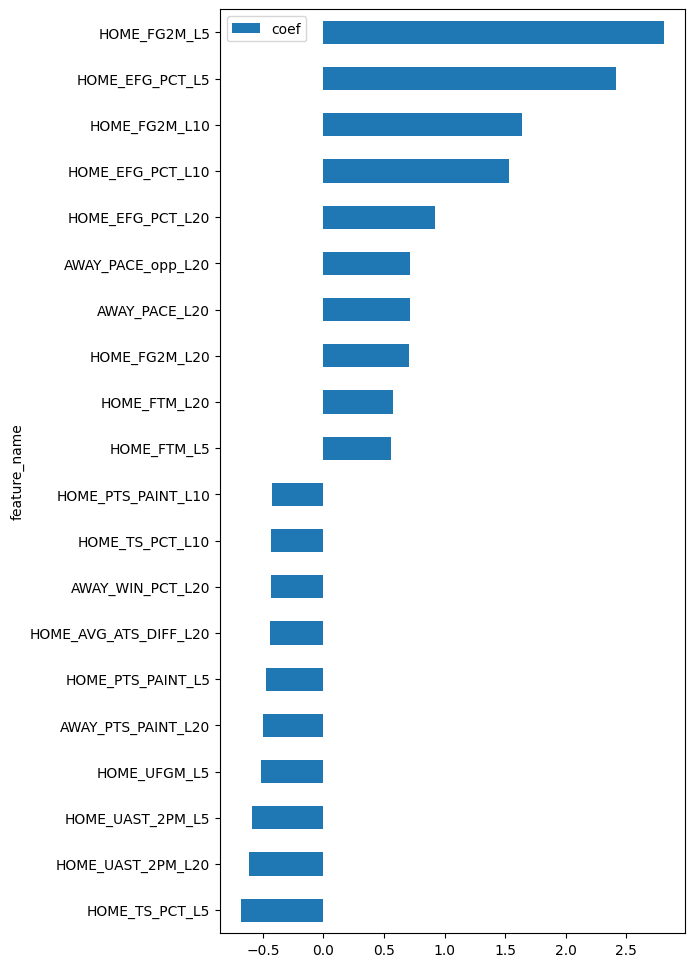

In [150]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[0], X_train)

In [151]:
sgd_coef_df.sort_values(['coef'], ascending=False)

,feature_name,coef
0,HOME_FG2M_L5,2.808808
87,HOME_EFG_PCT_L5,2.417692
94,HOME_FG2M_L10,1.636495
181,HOME_EFG_PCT_L10,1.534591
275,HOME_EFG_PCT_L20,0.919004
...,...,...
506,AWAY_PTS_PAINT_L20,-0.501867
26,HOME_UFGM_L5,-0.518646
36,HOME_UAST_2PM_L5,-0.592218
224,HOME_UAST_2PM_L20,-0.611971


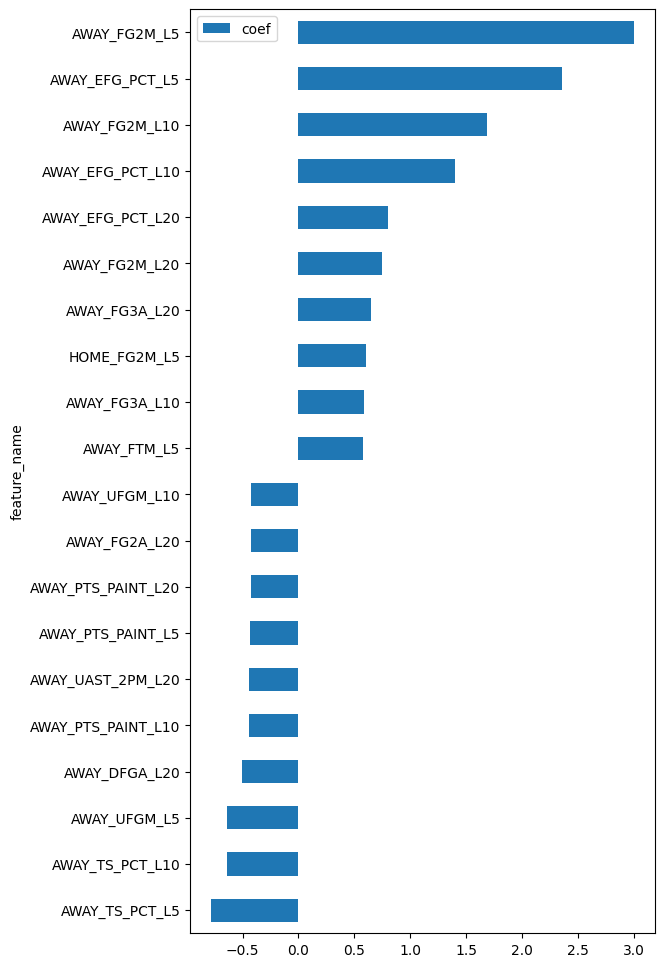

In [152]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[1], X_train)

LGBoost or XGBoost


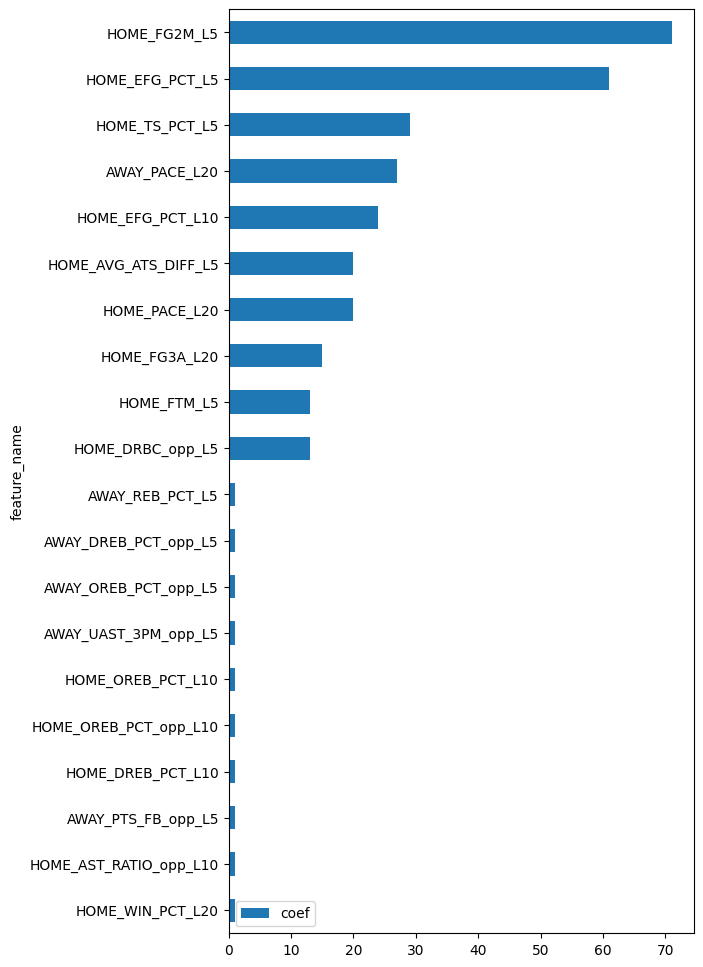

In [153]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[0], X_train)

LGBoost or XGBoost


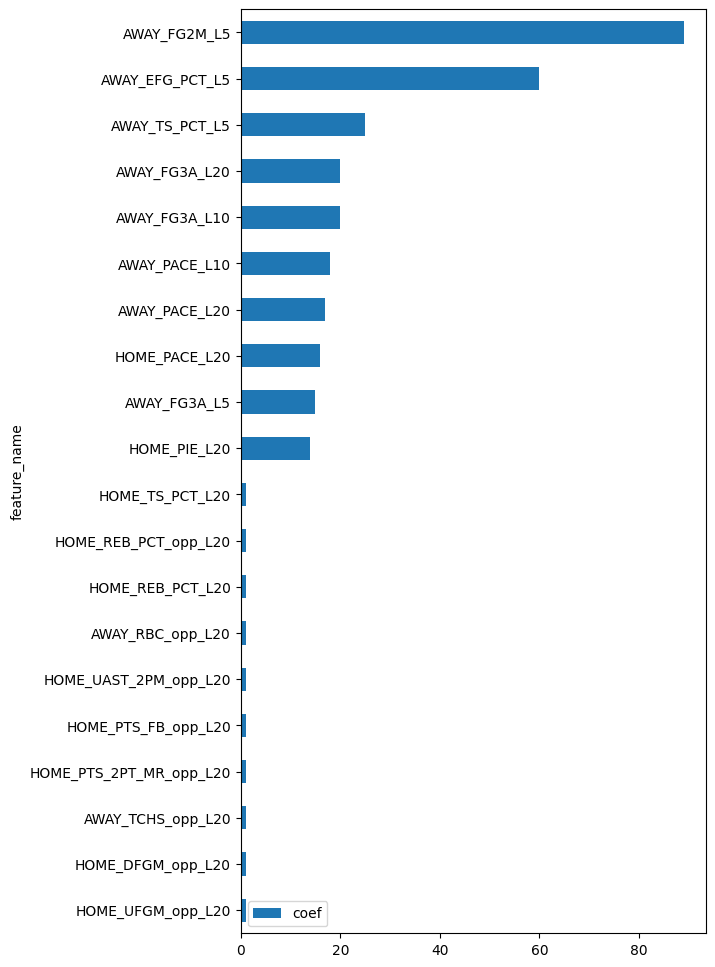

In [154]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[1], X_train)